In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import shapiro, zscore, lognorm
from sklearn.preprocessing import MinMaxScaler
import pylab
import tensorflow
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint 
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.optimizers import SGD
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from plotnine import ggplot
import geopandas as gpd
import geodatasets
import shapely
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point, LineString, Polygon
import folium
import pyproj
import rtree
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

1. Features: 2002-2019
2. NN_WNV: 1999-2020
3. N_WNV: 2000-2021

Common range: 2002-2019 (18 years)
18 years x 3109 counties = 55962 rows 

At this point, we will spend some time investigating the data. 

# Features: 
To begin with, the file example_features.csv has 23 columns described here (see example_features.md in GitHub flavivirus-data-osf repository for more detailed descriptions of columns):
1. FIPS code : US county code
2. Year : 2002-2019
3. Week : 1- 52
4. AVI : Count detections in birds
5. EQU : Count detections in horses
6. MOS : Count detections in mosquitos
7. SEN : Count detections in domestic chickens
8. PPT : Maximum precipitation for week (scaled and centered)
9. TEMP : Maximum temperature for week (scaled and centered)
10. None (Drought Reports 10-15)
11. D0
12. D1
13. D2
14. D3
15. D4
16. Richness : Host Species Richness
17. Horses : Crude estimate for total number of horses in the county.
18. s_DEM : Topograph
19. s.EstPop : Population
20. s.Pov_pct : Poverty 
21. s.Med_income : Median household income
22. Area.S : County area
23. Month : January - December

and $2,910,024$ rows, one row for each county(3109) x week(52) x year(18) = 2,910,024.   

# Classifiers:

We will concatenate files human_nonneuroinvasive_wnv_1999-2020.csv and human_neuroinvasive_wnv_2000-2021.csv into a single file with a column "Total" for binary classification disease detection and columns "Count(Yn)" (number of neuroinvasive cases) and "Count(Ynn)" (number of nonneuroinvasive cases) for multi-classification disease detection. Data description for these files: 

human_neuroinvasive_wnv_2000-2021.csv: 68,376 rows x 6 columns where each row corresponds to a given US county in a given year (3109 counties x 22 years = 68,398 rows > 68,376 rows, so there is some missing information that will need to be sorted.) Column descriptions are as follows:
1. FIPS
2. County
3. State
4. Location
5. Year (2000-2021)
6. Count (number of reported WNV detections per county per year)

human_nonneuroinvasive_wnv_1999-2020.csv: 6,732 rows x 5 columns where each row corresponds to a given US county in a given year. (3109 counties x 22 years = 68,398 rows >> 6,732 - I assume that counties reporting 0 detections for a given year are not represented.)
Column descriptions are as follows:
1. State
2. County
3. FIPS
4. Year (1999-2020)
5. Count (number of reported WNV detections per county per year)

# To reduce dimensionality, preprocess the dataframe, build, train, and test a model, the following tasks will be performed:
1. Filter years and months of interest
2. Combine all ZOO detections into a single column
3. Aggregate rows of features corresponding to relevant months and years into a single row per county per year
4. Filter and group classifiers in the same way and align all data
5. Consider Models (binary vs multi-classification models)
6. Missing Data
7. Normalize 
8. Split into training and testing
9. Build Model
10. Compile, Train, and Test
11. Summary and Results

In [2]:
#read in file
df = pd.read_csv(r"C:\Users\amooney\ORISE\USDA\Python\example_features.csv") 

# 1. Filter months of Interest

In [3]:
active_months =["April", "May", "June", "July","August","September"] #choose a subset of months to work with
mask = df['Month'].isin(active_months) #define a mask
reduced_df=df[mask]
reduced_df.head()

,FIPS,Year,Week,AVI,EQU,MOS,SEN,PPT,Temp,None,...,D3,D4,Richness,Horses,s_DEM,s.EstPop,s.Pov_pct,s.Med_income,Area.S,Month
40417,4003,2002,14,0,0,0,0,-1.735359,1.715811,0.0,...,0.0,0.0,55,7226.924000,2.618147,0.066044,0.175648,-0.875392,3.994242,April
40418,4009,2002,14,0,0,0,0,-1.482260,1.819129,0.0,...,0.0,0.0,45,2297.984338,2.637895,-0.206849,1.125349,-1.262496,2.797780,April
40419,4012,2002,14,0,0,0,0,-1.726572,1.888379,0.0,...,0.0,0.0,33,298.840027,0.555184,-0.250198,0.830614,-1.555611,2.696061,April
40420,4015,2002,14,0,0,0,0,-1.289661,2.069447,0.0,...,0.0,0.0,43,2710.357716,1.887487,0.211931,0.011906,-1.065716,9.513779,April
40421,4023,2002,14,0,0,0,0,-1.772751,1.557414,0.0,...,0.0,0.0,54,2942.269804,1.899335,-0.185474,0.617750,-1.085419,0.204342,April


In [4]:
reduced_df=reduced_df.reset_index() #reset indices

In [5]:
reduced_df.head()

,index,FIPS,Year,Week,AVI,EQU,MOS,SEN,PPT,Temp,...,D3,D4,Richness,Horses,s_DEM,s.EstPop,s.Pov_pct,s.Med_income,Area.S,Month
0,40417,4003,2002,14,0,0,0,0,-1.735359,1.715811,...,0.0,0.0,55,7226.924000,2.618147,0.066044,0.175648,-0.875392,3.994242,April
1,40418,4009,2002,14,0,0,0,0,-1.482260,1.819129,...,0.0,0.0,45,2297.984338,2.637895,-0.206849,1.125349,-1.262496,2.797780,April
2,40419,4012,2002,14,0,0,0,0,-1.726572,1.888379,...,0.0,0.0,33,298.840027,0.555184,-0.250198,0.830614,-1.555611,2.696061,April
3,40420,4015,2002,14,0,0,0,0,-1.289661,2.069447,...,0.0,0.0,43,2710.357716,1.887487,0.211931,0.011906,-1.065716,9.513779,April
4,40421,4023,2002,14,0,0,0,0,-1.772751,1.557414,...,0.0,0.0,54,2942.269804,1.899335,-0.185474,0.617750,-1.085419,0.204342,April


In [6]:
reduced_df=reduced_df.drop(['index'], axis=1) #drop the redundant index column. 

In [7]:
reduced_df.head()

,FIPS,Year,Week,AVI,EQU,MOS,SEN,PPT,Temp,None,...,D3,D4,Richness,Horses,s_DEM,s.EstPop,s.Pov_pct,s.Med_income,Area.S,Month
0,4003,2002,14,0,0,0,0,-1.735359,1.715811,0.0,...,0.0,0.0,55,7226.924000,2.618147,0.066044,0.175648,-0.875392,3.994242,April
1,4009,2002,14,0,0,0,0,-1.482260,1.819129,0.0,...,0.0,0.0,45,2297.984338,2.637895,-0.206849,1.125349,-1.262496,2.797780,April
2,4012,2002,14,0,0,0,0,-1.726572,1.888379,0.0,...,0.0,0.0,33,298.840027,0.555184,-0.250198,0.830614,-1.555611,2.696061,April
3,4015,2002,14,0,0,0,0,-1.289661,2.069447,0.0,...,0.0,0.0,43,2710.357716,1.887487,0.211931,0.011906,-1.065716,9.513779,April
4,4023,2002,14,0,0,0,0,-1.772751,1.557414,0.0,...,0.0,0.0,54,2942.269804,1.899335,-0.185474,0.617750,-1.085419,0.204342,April


In [8]:
reduced_df.head(20) #looking for rows that have more than one non-zero column: avi, equ, mos, sen;
                    #index's 161648 sum should be 3

,FIPS,Year,Week,AVI,EQU,MOS,SEN,PPT,Temp,None,...,D3,D4,Richness,Horses,s_DEM,s.EstPop,s.Pov_pct,s.Med_income,Area.S,Month
0,4003,2002,14,0,0,0,0,-1.735359,1.715811,0.0,...,0.0,0.0,55,7226.924000,2.618147,0.066044,0.175648,-0.875392,3.994242,April
1,4009,2002,14,0,0,0,0,-1.482260,1.819129,0.0,...,0.0,0.0,45,2297.984338,2.637895,-0.206849,1.125349,-1.262496,2.797780,April
2,4012,2002,14,0,0,0,0,-1.726572,1.888379,0.0,...,0.0,0.0,33,298.840027,0.555184,-0.250198,0.830614,-1.555611,2.696061,April
3,4015,2002,14,0,0,0,0,-1.289661,2.069447,0.0,...,0.0,0.0,43,2710.357716,1.887487,0.211931,0.011906,-1.065716,9.513779,April
4,4023,2002,14,0,0,0,0,-1.772751,1.557414,0.0,...,0.0,0.0,54,2942.269804,1.899335,-0.185474,0.617750,-1.085419,0.204342,April
5,5005,2002,14,0,0,0,0,1.162508,0.550466,100.0,...,0.0,0.0,26,3265.441618,-0.397966,-0.190209,-0.233706,-1.208081,-0.291303,April
6,5023,2002,14,0,0,0,0,0.700531,0.530082,100.0,...,0.0,0.0,6,4453.482277,-0.353205,-0.234726,-0.069965,-1.031508,-0.286909,April
7,5025,2002,14,0,0,0,0,0.082229,0.675964,100.0,...,0.0,0.0,0,313.220353,-0.709978,-0.284316,-0.315577,-0.859546,-0.282053,April
8,5027,2002,14,0,0,0,0,0.542765,0.855285,100.0,...,0.0,0.0,21,1312.719341,-0.670483,-0.231617,0.715995,-1.282450,-0.154269,April
9,5037,2002,14,0,0,0,0,-0.568665,0.490779,100.0,...,0.0,0.0,4,677.827652,-0.675749,-0.251326,0.617750,-1.296703,-0.263355,April


# 2. Combine Zoo

In [9]:
reduced_df['AVI']=reduced_df['AVI']+reduced_df['EQU']+reduced_df['MOS']+reduced_df['SEN'] #combine all zoo indicators

In [10]:
reduced_df=reduced_df.drop(["EQU", "MOS" , "SEN"],axis=1) #dropping columns that were previously combined

In [11]:
reduced_df=reduced_df.rename(columns={"AVI": "ZOO"}) #rename column to ZOO

In [12]:
reduced_df.tail(20)

,FIPS,Year,Week,ZOO,PPT,Temp,None,D0,D1,D2,D3,D4,Richness,Horses,s_DEM,s.EstPop,s.Pov_pct,s.Med_income,Area.S,Month
1467428,50001,2019,39,0,0.588999,-0.990614,71.52,28.48,0.00,0.0,0.0,0.0,41,3264.8000,0.228690,-0.195038,-0.151836,-0.163733,-0.122805,September
1467429,50005,2019,39,0,0.460031,-1.341403,31.88,68.12,0.00,0.0,0.0,0.0,18,1573.3130,0.086508,-0.216054,-0.151836,-0.163733,-0.236897,September
1467430,50007,2019,39,0,0.523677,-1.064824,19.78,80.22,0.00,0.0,0.0,0.0,36,3673.5040,0.094407,0.206944,-0.151836,-0.163733,-0.266425,September
1467431,50011,2019,39,0,-0.062759,-1.049863,50.24,49.76,0.00,0.0,0.0,0.0,26,993.5485,0.069393,-0.155823,-0.151836,-0.163733,-0.210587,September
1467432,50013,2019,39,0,-0.274798,-1.080768,77.85,22.15,0.00,0.0,0.0,0.0,23,2077.1670,-0.754739,-0.289180,-0.151836,-0.163733,-0.590231,September
1467433,50017,2019,39,0,0.286297,-1.113491,4.14,95.86,0.00,0.0,0.0,0.0,27,2336.4560,0.086508,-0.220159,-0.151836,-0.163733,-0.210575,September
1467434,53049,2019,39,0,2.296034,-1.281848,0.00,100.00,0.00,0.0,0.0,0.0,27,321.3027,-0.084638,-0.242095,-0.151836,-0.163733,-0.006263,September
1467435,53051,2019,39,0,-0.081367,-1.976822,22.42,77.58,49.83,0.0,0.0,0.0,21,1084.9930,1.406962,-0.268665,-0.151836,-0.163733,0.346722,September
1467436,53053,2019,39,0,2.399791,-1.415007,0.00,100.00,14.41,0.0,0.0,0.0,35,10674.8500,3.306679,2.496391,-0.151836,-0.163733,0.570425,September
1467437,53055,2019,39,0,-0.185941,-1.800498,0.00,100.00,0.00,0.0,0.0,0.0,24,652.5896,-0.388750,-0.257557,-0.151836,-0.163733,-0.544287,September


# 3. Aggregate

In [13]:
grouped_x = reduced_df.groupby(['Year', 'FIPS']).agg({'ZOO':sum, 'PPT': sum,'Temp': max, 'D0': 'mean' , 'D1':'mean', 'D2':'mean',
                                                      'D3':'mean', 'D4':'mean', 'Richness': 'mean', 'Horses': max, 
                                                      's_DEM': 'mean', 's.EstPop': 'mean', 's.Pov_pct': 'mean', 
                                                      's.Med_income':'mean', 'Area.S':max })

# 4. Now, we need to filter and group the classifier dataframes in the same way as the features dataframe. 

In [14]:
#read in non-neuroinvasive WNV data
nn_wnv = pd.read_csv(r"C:\Users\amooney\ORISE\USDA\Python\human_nonneuroinvasive_wnv_1999-2020.csv") 

In [15]:
active_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019] #choose a subset of years to work with
mask = nn_wnv['Year'].isin(active_years) #define a mask and select the appropriate subset of the df
my_yearnn = nn_wnv[mask]
my_yearnn.head()

,State,County,fipscode,Year,COUNT
0,AL,Autauga County,1001,2017,3
1,AL,Baldwin County,1003,2003,4
2,AL,Baldwin County,1003,2004,1
3,AL,Baldwin County,1003,2012,2
4,AL,Baldwin County,1003,2016,1


In [16]:
my_yearnn=my_yearnn.rename(columns={"Year" : "year", "fipscode":"fips"})

In [17]:
grouped_ynn=my_yearnn.groupby(['year', 'fips']).agg({'COUNT':sum}) #group by year and fipscode and aggregate count with sum
grouped_ynn.tail()


COUNT
year fips        
2019 53005      2
     55071      1
     55079      1
     56011      1
     56025      1

In [18]:
grouped_ynn.shape #lots of counties not represented 

(6638, 1)

In [19]:
#read in neuroinvasive WNV data
n_wnv = pd.read_csv(r"C:\Users\amooney\ORISE\USDA\Python\human_neuroinvasive_wnv_2000-2021.csv")

In [20]:
active_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019] #choose a subset of years to work with
mask = n_wnv['year'].isin(active_years) #define a mask and select the appropriate subset of the df
my_yearn = n_wnv[mask]
my_yearn.head()

,fips,county,state,location,year,count
2,1001,Autauga,Alabama,Alabama-Autauga,2002,1
3,1001,Autauga,Alabama,Alabama-Autauga,2003,0
4,1001,Autauga,Alabama,Alabama-Autauga,2004,0
5,1001,Autauga,Alabama,Alabama-Autauga,2005,0
6,1001,Autauga,Alabama,Alabama-Autauga,2006,0


In [21]:
grouped_yn=my_yearn.groupby(['year','fips']).agg({"count":sum}) #group by year and fips
grouped_yn.tail(20)

count
year fips        
2019 56007      0
     56009      0
     56011      0
     56013      0
     56015      0
     56017      0
     56019      0
     56021      0
     56023      0
     56025      0
     56027      0
     56029      0
     56031      0
     56033      0
     56035      0
     56037      0
     56039      0
     56041      0
     56043      1
     56045      0

In [22]:
grouped_yn.shape 

(55944, 1)

In [23]:
grouped_yn=grouped_yn.reset_index() #resetting indices for neuroinvasive wnv

In [24]:
(grouped_yn['year']==2019).sum() #all years missing one county

3108

In [25]:
grouped_ynn=grouped_ynn.reset_index()

In [26]:
#merging ynn and yn
merged_y=grouped_yn.merge(grouped_ynn, how='left')

In [27]:
merged_y.tail()

,year,fips,count,COUNT
55939,2019,56037,0,NaN
55940,2019,56039,0,NaN
55941,2019,56041,0,NaN
55942,2019,56043,1,NaN
55943,2019,56045,0,NaN


In [28]:
merged_y.columns

Index(['year', 'fips', 'count', 'COUNT'], dtype='object')

In [29]:
merged_y.shape 

(55944, 4)

In [30]:
#make a copy of merged_y
copy_y=merged_y.copy()

In [31]:
#fill NaN with 0 in copy so that NaN do not affect total
copy_y=copy_y.fillna(0)

In [32]:
copy_y.head()

,year,fips,count,COUNT
0,2002,1001,1,0.0
1,2002,1003,0,0.0
2,2002,1005,0,1.0
3,2002,1007,0,0.0
4,2002,1009,0,0.0


In [33]:
total = copy_y['count'] + copy_y['COUNT']  
merged_y = merged_y.assign(total=total)

In [34]:
merged_y.head()

,year,fips,count,COUNT,total
0,2002,1001,1,NaN,1.0
1,2002,1003,0,NaN,0.0
2,2002,1005,0,1.0,1.0
3,2002,1007,0,NaN,0.0
4,2002,1009,0,NaN,0.0


In [35]:
#Get X and reset index to compare fips and years 
grouped_x=grouped_x.reset_index()

In [36]:
#make a copy of year and fips columns for merging and comparing
new = grouped_x[['Year', 'FIPS']].copy()

In [37]:
#Rename columns for consistancy
merged_y=merged_y.rename(columns={"fips":"FIPS", "year":"Year", "count":"Count(Yn)", "COUNT":"Count(Ynn)"})

In [38]:
df_all = new.merge(merged_y.drop_duplicates(), on=['Year','FIPS'],
                   how='left', indicator=True)

In [39]:
df_all.head()

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
0,2002,1001,1.0,NaN,1.0,both
1,2002,1003,0.0,NaN,0.0,both
2,2002,1005,0.0,1.0,1.0,both
3,2002,1007,0.0,NaN,0.0,both
4,2002,1009,0.0,NaN,0.0,both


In [40]:
df_all.shape

(55962, 6)

In [41]:
df_all['_merge'] == 'left_only' 

0        False
1        False
2        False
3        False
4        False
         ...  
55957    False
55958    False
55959    False
55960    False
55961    False
Name: _merge, Length: 55962, dtype: bool

In [42]:
df_all.loc[df_all['_merge'] != 'both'] #all rows in grouped_x that are not in merged_y

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
2383,2002,46113,NaN,NaN,NaN,left_only
2882,2002,51515,NaN,NaN,NaN,left_only
5492,2003,46113,NaN,NaN,NaN,left_only
5991,2003,51515,NaN,NaN,NaN,left_only
8601,2004,46113,NaN,NaN,NaN,left_only
9100,2004,51515,NaN,NaN,NaN,left_only
11710,2005,46113,NaN,NaN,NaN,left_only
12209,2005,51515,NaN,NaN,NaN,left_only
14819,2006,46113,NaN,NaN,NaN,left_only
15318,2006,51515,NaN,NaN,NaN,left_only


In [43]:
df_all2 = merged_y.merge(new.drop_duplicates(), on=['Year','FIPS'],
                   how='left', indicator=True)

In [44]:
df_all2.head()

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
0,2002,1001,1,NaN,1.0,both
1,2002,1003,0,NaN,0.0,both
2,2002,1005,0,1.0,1.0,both
3,2002,1007,0,NaN,0.0,both
4,2002,1009,0,NaN,0.0,both


In [45]:
df_all2.shape

(55944, 6)

In [46]:
df_all2['_merge'] == 'left_only' 

0        False
1        False
2        False
3        False
4        False
         ...  
55939    False
55940    False
55941    False
55942    False
55943    False
Name: _merge, Length: 55944, dtype: bool

In [47]:
df_all2.loc[df_all2['_merge'] != 'both'] #all rows in merged_y that are not in grouped_x

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
2378,2002,46102,0,NaN,0.0,left_only
5486,2003,46102,8,19.0,27.0,left_only
8594,2004,46102,0,NaN,0.0,left_only
11702,2005,46102,0,1.0,1.0,left_only
14810,2006,46102,1,NaN,1.0,left_only
17918,2007,46102,2,1.0,3.0,left_only
21026,2008,46102,0,NaN,0.0,left_only
24134,2009,46102,0,NaN,0.0,left_only
27242,2010,46102,0,NaN,0.0,left_only
30350,2011,46102,0,NaN,0.0,left_only


In [48]:
grouped_x.loc[2378, "FIPS"]=46102

In [49]:
grouped_x.loc[5486, "FIPS"]=46102

In [50]:
grouped_x.loc[8594, "FIPS"]=46102

In [51]:
grouped_x.loc[11702, "FIPS"]=46102

In [52]:
grouped_x.loc[14810, "FIPS"]=46102

In [53]:
grouped_x.loc[17918, "FIPS"]=46102

In [54]:
grouped_x.loc[21026, "FIPS"]=46102

In [55]:
grouped_x.loc[24134, "FIPS"]=46102

In [56]:
grouped_x.loc[27242, "FIPS"]=46102

In [57]:
grouped_x.loc[30350, "FIPS"]=46102

In [58]:
grouped_x.loc[33458, "FIPS"]=46102

In [59]:
grouped_x.loc[36566, "FIPS"]=46102

In [60]:
grouped_x.loc[39674, "FIPS"]=46102

In [61]:
grouped_x.loc[42782, "FIPS"]=46102

In [62]:
grouped_x.loc[45890, "FIPS"]=46102

In [63]:
grouped_x.loc[48998, "FIPS"]=46102

In [64]:
grouped_x.loc[52106, "FIPS"]=46102

In [65]:
grouped_x.loc[55214, "FIPS"]=46102

In [66]:
def insert_row(row_num, row_val, df):
    df1=df[0:row_num] #slice upper portion of df
    df2 = df[row_num:] #store lower portion of df for concat later
    df1.loc[row_num]=row_val #insert the new row in the upper half at row_num
    new_df = pd.concat([df1,df2]) #concat df1 and df2
    new_df.index = [*range(new_df.shape[0])] #reassign index labels
    return new_df

In [67]:
add_list=merged_y.index[merged_y['FIPS'] == 51510].tolist()

In [69]:
merged_y.columns

Index(['Year', 'FIPS', 'Count(Yn)', 'Count(Ynn)', 'total'], dtype='object')

In [70]:
merged_y.shape

(55944, 5)

In [71]:
year_list=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
for i in range(len(year_list)):
    row_val=[year_list[i],'51515','NaN','NaN','0']
    inter_df=insert_row(add_list[i],row_val, merged_y)
    merged_y=inter_df
print(merged_y.shape)

<ipython-input-66-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-66-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-66-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-66-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

(55962, 5)


<ipython-input-66-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-66-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-66-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [72]:
merged_y.shape

(55962, 5)

In [73]:
df_check = grouped_x.merge(merged_y.drop_duplicates(), on=['Year','FIPS'],
                   how='left', indicator=True)

In [74]:
df_check['_merge'] == 'left_only' 

0        False
1        False
2        False
3        False
4        False
         ...  
55957    False
55958    False
55959    False
55960    False
55961    False
Name: _merge, Length: 55962, dtype: bool

In [75]:
df_all2.loc[df_all2['_merge'] != 'both'] 

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
2378,2002,46102,0,NaN,0.0,left_only
5486,2003,46102,8,19.0,27.0,left_only
8594,2004,46102,0,NaN,0.0,left_only
11702,2005,46102,0,1.0,1.0,left_only
14810,2006,46102,1,NaN,1.0,left_only
17918,2007,46102,2,1.0,3.0,left_only
21026,2008,46102,0,NaN,0.0,left_only
24134,2009,46102,0,NaN,0.0,left_only
27242,2010,46102,0,NaN,0.0,left_only
30350,2011,46102,0,NaN,0.0,left_only


In [76]:
df_check2 = merged_y.merge(grouped_x.drop_duplicates(), on=['Year','FIPS'],
                   how='left', indicator=True)

In [77]:
df_check['_merge'] == 'left_only' 

0        False
1        False
2        False
3        False
4        False
         ...  
55957    False
55958    False
55959    False
55960    False
55961    False
Name: _merge, Length: 55962, dtype: bool

In [78]:
df_all2.loc[df_all2['_merge'] != 'both'] 

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
2378,2002,46102,0,NaN,0.0,left_only
5486,2003,46102,8,19.0,27.0,left_only
8594,2004,46102,0,NaN,0.0,left_only
11702,2005,46102,0,1.0,1.0,left_only
14810,2006,46102,1,NaN,1.0,left_only
17918,2007,46102,2,1.0,3.0,left_only
21026,2008,46102,0,NaN,0.0,left_only
24134,2009,46102,0,NaN,0.0,left_only
27242,2010,46102,0,NaN,0.0,left_only
30350,2011,46102,0,NaN,0.0,left_only


In [79]:
y=merged_y

In [80]:
y.shape

(55962, 5)

# 5. Considering Models
We currently have a dataset that has 6218 rows with 17 features and 3 classifiers. 
Classifiers:
1. Count for Neuroinvasive WNV detection
2. Count for Non-neuroinvasive WNV detection
3. Total (sum of 1 and 2)

We will focus on discussing the model options for handling different types of classifiers.
1. Binary Classification:
This is a model that would consider *any* disease detection as True, and no disease detection as False. We would not have to handle missing data in this case as all rows have data in the "Total" column.
2. Multi-Classification:
Multi-label classification involves predicting more class labels. Here, class labels are not mutually exclusive as they are in the binary classification case. Classifications would be detection of WNV Neuroinvasive, WNV Non-neuroinvasive, and no WNV detection.  

In [81]:
#Extract the "total" column from y
bin_y=y.iloc[:,4]

In [82]:
bin_y=pd.DataFrame(bin_y)

In [83]:
bin_y.tail()

,total
55957,0.0
55958,0.0
55959,0.0
55960,1.0
55961,0.0


In [84]:
bin_y[bin_y != 0] = 1

In [85]:
bin_y.tail()

,total
55957,0.0
55958,0.0
55959,0.0
55960,1
55961,0.0


In [86]:
bin_y['total'].value_counts()[1] #out of 6218 samples, 1820 are positive for WNV. 

10745

# 6.1 Binary Classification Model
As previously discussed, our binary classification model should have no NaN values to deal with. Still, we need to ensure all dytpes are appropriate for feeding into a keras model. 

In [87]:
bin_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55962 entries, 0 to 55961
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   total   55962 non-null  object
dtypes: object(1)
memory usage: 874.4+ KB


In [88]:
bin_y['total']=bin_y['total'].apply(np.int64)

In [89]:
bin_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55962 entries, 0 to 55961
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   total   55962 non-null  int64
dtypes: int64(1)
memory usage: 874.4 KB


In [90]:
grouped_x.columns

Index(['Year', 'FIPS', 'ZOO', 'PPT', 'Temp', 'D0', 'D1', 'D2', 'D3', 'D4',
       'Richness', 'Horses', 's_DEM', 's.EstPop', 's.Pov_pct', 's.Med_income',
       'Area.S'],
      dtype='object')

In [91]:
y.head()

,Year,FIPS,Count(Yn),Count(Ynn),total
0,2002,1001,1,NaN,1.0
1,2002,1003,0,NaN,0.0
2,2002,1005,0,1.0,1.0
3,2002,1007,0,NaN,0.0
4,2002,1009,0,NaN,0.0


# 7. Normalize and Resample

In [92]:
scaler=MinMaxScaler()
scaled_x=scaler.fit_transform(grouped_x)

# Resampling
1. Random Oversampling: Randomly select instances of minority class to duplicate
2. Random Undersampling: Randomly delete instances of majority class

In [93]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
oversample=RandomOverSampler(sampling_strategy="minority")

In [94]:
X_over, y_over = oversample.fit_resample(grouped_x, bin_y)

In [95]:
y_over['total'].value_counts()[1]

45217

In [96]:
y_over['total'].value_counts()[0]

45217

# 8.1 Splitting for Binary Classification Model
Split bin_y

In [97]:
X_train, X_test, y_train, y_test = train_test_split(scaled_x, bin_y , 
                                   random_state=0,  
                                   test_size=0.20,  
                                   shuffle=True)

In [98]:
from keras.utils import normalize
X_train=normalize(X_train, axis=1)
X_test=normalize(X_test, axis=1)

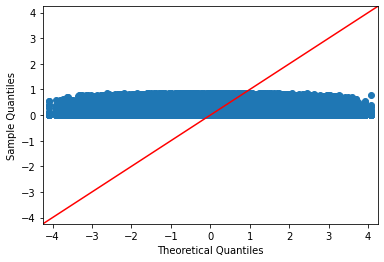

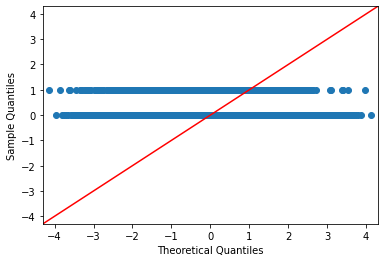

In [99]:
#visualize prescaled data
fig1= sm.qqplot(X_train, line='45')
fig2=sm.qqplot(bin_y,line='45')

# Build, Compile, and Check Results

# Results 1:
1. ADAM 
2. LR=0.0001
3. Dense 32 relu, Dense 64 relu, Dropout 0.6, Dense 1, hard sigmoid
4. Mean Squared Error
5. No resampling
6. Normalized with MinMax before splitting
7. 300 Epochs
8. Batch size =32

In [100]:
type(X_train)

numpy.ndarray

In [101]:
type(y_train)

pandas.core.frame.DataFrame

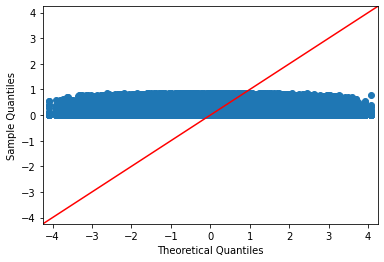

In [102]:
fig1= sm.qqplot(X_train, line='45')

In [103]:
from tensorflow.keras.layers import InputLayer
from keras.optimizers import SGD
Num_epochs=300
Batch_size=32

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], )))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
#model.add(Dense(128,activation='hard_sigmoid'))
model.add(Dense(1, activation='hard_sigmoid'))
print(model.summary())


opt= SGD(learning_rate=0.01)
opt1=keras.optimizers.Adam(learning_rate=0.0001)
loss='mean_squared_error'
loss1='binary_crossentropy'
model.compile(loss=loss, optimizer=opt1, metrics=['accuracy'])

#checkpoint: store the best model
metric = 'val_accuracy'
ckpt_model = 'wnv_weights.best.hdf5'
checkpoint = ModelCheckpoint(ckpt_model,monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list=[checkpoint]

print('Starting Training')
#train the model, store the results for plotting
history=model.fit(X_train, 
                  y_train, 
                  validation_data=(X_test, y_test), 
                  epochs=Num_epochs, 
                  batch_size=Batch_size, 
                  callbacks=callbacks_list, 
                  verbose=0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
None
Starting Training

Epoch 1: val_accuracy improved from -inf to 0.80658, saving model to wnv_weights.best.hdf5

Epoch 2: val_accuracy did not improve from 0.80658

Epoch 3: val_accur


Epoch 100: val_accuracy did not improve from 0.83954

Epoch 101: val_accuracy improved from 0.83954 to 0.83963, saving model to wnv_weights.best.hdf5

Epoch 102: val_accuracy did not improve from 0.83963

Epoch 103: val_accuracy did not improve from 0.83963

Epoch 104: val_accuracy did not improve from 0.83963

Epoch 105: val_accuracy improved from 0.83963 to 0.84008, saving model to wnv_weights.best.hdf5

Epoch 106: val_accuracy did not improve from 0.84008

Epoch 107: val_accuracy did not improve from 0.84008

Epoch 108: val_accuracy improved from 0.84008 to 0.84026, saving model to wnv_weights.best.hdf5

Epoch 109: val_accuracy improved from 0.84026 to 0.84035, saving model to wnv_weights.best.hdf5

Epoch 110: val_accuracy did not improve from 0.84035

Epoch 111: val_accuracy did not improve from 0.84035

Epoch 112: val_accuracy did not improve from 0.84035

Epoch 113: val_accuracy did not improve from 0.84035

Epoch 114: val_accuracy did not improve from 0.84035

Epoch 115: val_ac


Epoch 243: val_accuracy did not improve from 0.84383

Epoch 244: val_accuracy did not improve from 0.84383

Epoch 245: val_accuracy did not improve from 0.84383

Epoch 246: val_accuracy did not improve from 0.84383

Epoch 247: val_accuracy did not improve from 0.84383

Epoch 248: val_accuracy did not improve from 0.84383

Epoch 249: val_accuracy did not improve from 0.84383

Epoch 250: val_accuracy did not improve from 0.84383

Epoch 251: val_accuracy did not improve from 0.84383

Epoch 252: val_accuracy did not improve from 0.84383

Epoch 253: val_accuracy did not improve from 0.84383

Epoch 254: val_accuracy did not improve from 0.84383

Epoch 255: val_accuracy improved from 0.84383 to 0.84401, saving model to wnv_weights.best.hdf5

Epoch 256: val_accuracy did not improve from 0.84401

Epoch 257: val_accuracy did not improve from 0.84401

Epoch 258: val_accuracy did not improve from 0.84401

Epoch 259: val_accuracy did not improve from 0.84401

Epoch 260: val_accuracy did not improv

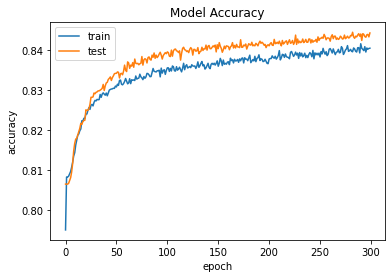

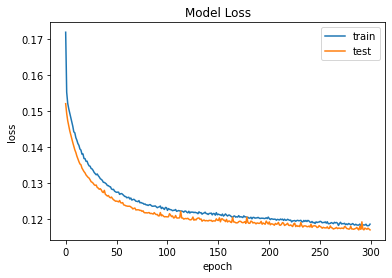

accuracy: 84.44%


In [104]:


# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


# print final accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    


350/350 [==============================] - 1s 3ms/step
[[9014   14]
 [1984  181]]


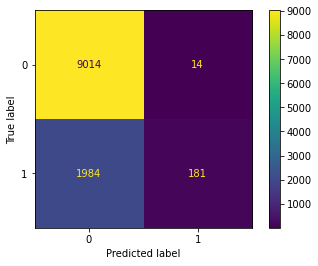

In [105]:
predictions = model.predict(X_test).astype(int)
y_pred=(predictions > 0.5)
cm= confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Duplicate Results Above:
1. ADAM 
2. LR=0.0001
3. Dense 32 relu, Dense 64 relu, Dropout 0.6, Dense 1, hard sigmoid
4. Mean Squared Error
5. No resampling
6. Normalized with MinMax before splitting
7. 300 Epochs
8. Batch size =32

In [106]:
type(X_train)

numpy.ndarray

In [107]:
type(y_train)

pandas.core.frame.DataFrame

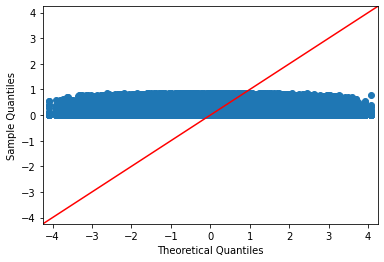

In [108]:
fig1= sm.qqplot(X_train, line='45')

In [109]:
from tensorflow.keras.layers import InputLayer
from keras.optimizers import SGD
Num_epochs=100
Batch_size=32

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], )))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
#model.add(Dense(128,activation='hard_sigmoid'))
model.add(Dense(1, activation='hard_sigmoid'))
print(model.summary())


opt= SGD(learning_rate=0.01)
opt1=keras.optimizers.Adam(learning_rate=0.0001)
loss='mean_squared_error'
loss1='binary_crossentropy'
model.compile(loss=loss, optimizer=opt1, metrics=['accuracy'])

#checkpoint: store the best model
metric = 'val_accuracy'
ckpt_model = 'wnv_weights.best.hdf5'
checkpoint = ModelCheckpoint(ckpt_model,monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list=[checkpoint]

print('Starting Training')
#train the model, store the results for plotting
history=model.fit(X_train, 
                  y_train, 
                  validation_data=(X_test, y_test), 
                  epochs=Num_epochs, 
                  batch_size=Batch_size, 
                  callbacks=callbacks_list, 
                  verbose=0)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                576       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
None
Starting Training

Epoch 1: val_accuracy improved from -inf to 0.80658, saving model to wnv_weights.best.hdf5

Epoch 2: val_accuracy did not improve from 0.80658

Epoch 3: val_acc


Epoch 98: val_accuracy improved from 0.83865 to 0.83883, saving model to wnv_weights.best.hdf5

Epoch 99: val_accuracy improved from 0.83883 to 0.83910, saving model to wnv_weights.best.hdf5

Epoch 100: val_accuracy did not improve from 0.83910


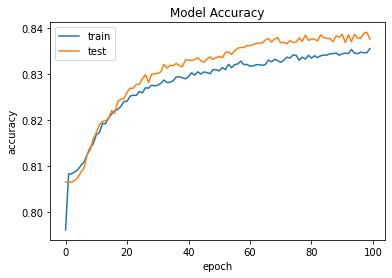

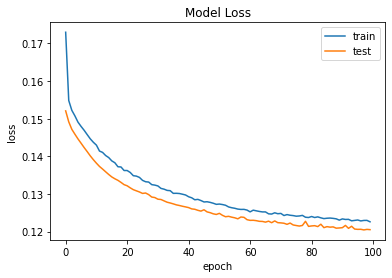

accuracy: 83.76%


In [110]:


# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


# print final accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    


350/350 [==============================] - 1s 3ms/step
[[9016   12]
 [2029  136]]


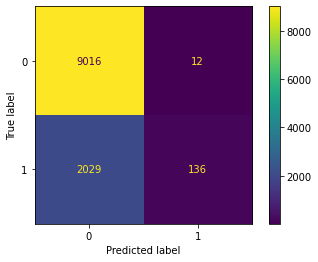

In [111]:
predictions = model.predict(X_test).astype(int)
y_pred=(predictions > 0.5)
cm= confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Same example as above with resampling:
1. ADAM 
2. LR=0.0001
3. Dense 32 relu, Dense 64 relu, Dropout 0.6, Dense 1, hard sigmoid
4. Mean Squared Error
5. No resampling
6. Normalized with MinMax before splitting
7. 300 Epochs
8. Batch size =32
9. Sampling technique: oversampling

# Receiver Operating Characteristic (ROC) Curve
ROC Curve give the optimal threshold
Area under the curve: 
1. Where true positives are above the threshold of 50% and true negatives are below the same threshold, AUC is 1.
2. If some positive data has a threshold below 50% the model will incorrectly classify those values, and AUC is <1 (80% means the model has an 80% chance of getting it correct. )
3. Equal chance of false positive and false negative, get a linear curve. 

Optimal cut off point is where the true positive rate is high and the false positive rate is low.
Based on this logic, the threshold is given by tpr-(1-fpr) is close to zero

In [112]:
from sklearn.metrics import roc_curve
y_preds=model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)


350/350 [==============================] - 1s 3ms/step


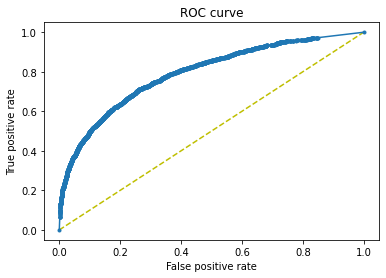

In [113]:
plt.figure(1)
plt.plot([0,1],[0,1],'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# Features Analysis:

In [114]:
y_shaped=np.ravel(y_train)

In [115]:
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y_shaped)

In [116]:
feature_names = [f"feature {i}" for i in range(scaled_x.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_transformed)

RandomForestClassifier(random_state=0)

In [117]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.071 seconds


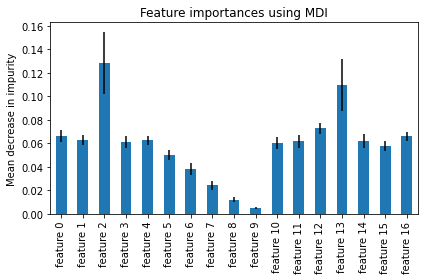

In [118]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [119]:
grouped_x.columns

Index(['Year', 'FIPS', 'ZOO', 'PPT', 'Temp', 'D0', 'D1', 'D2', 'D3', 'D4',
       'Richness', 'Horses', 's_DEM', 's.EstPop', 's.Pov_pct', 's.Med_income',
       'Area.S'],
      dtype='object')

In [120]:
from sklearn.inspection import permutation_importance
start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 78.530 seconds


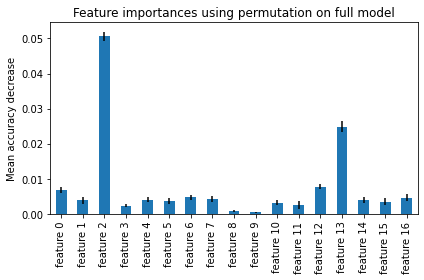

In [121]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


Correlation Coefficient:
In the heatmap, positive correlations are represented by blue, dark to light indicates strong to weak correlations respectively. Negative correlations are represented by red, dark to light indicates strong to weak correlations respectively. 

<Axes: >

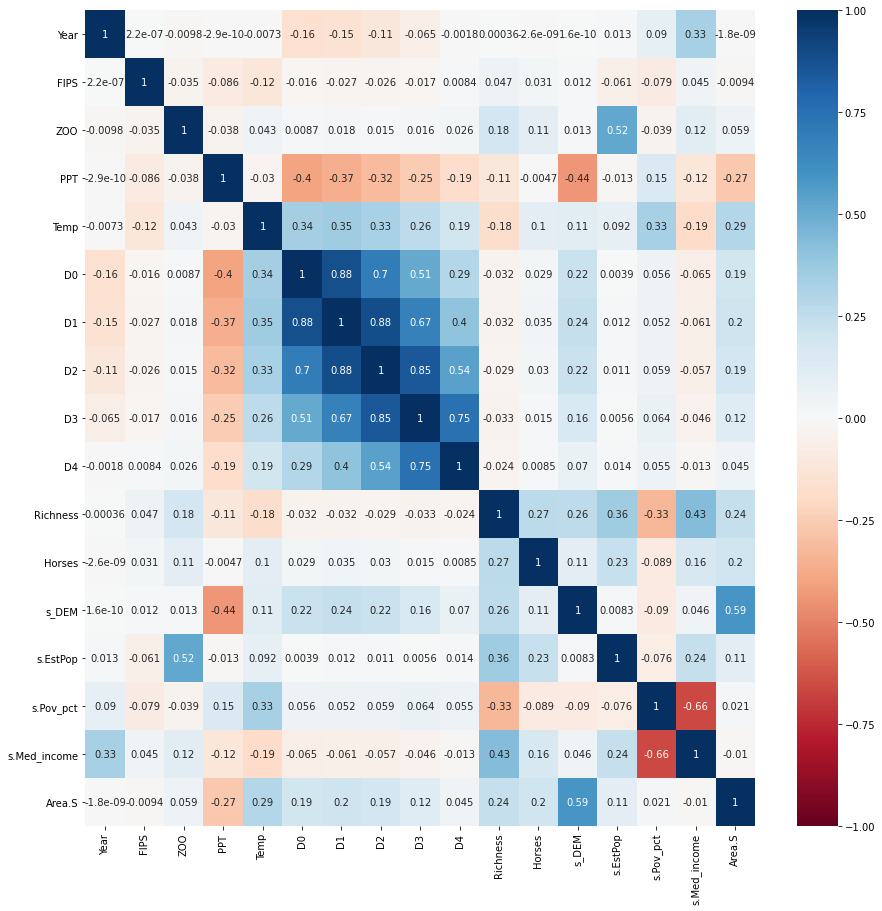

In [122]:
cor = grouped_x.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot = True, cmap='RdBu' , vmin=-1, vmax=1)

# Reducing Features:

In [123]:
grouped_x.columns

Index(['Year', 'FIPS', 'ZOO', 'PPT', 'Temp', 'D0', 'D1', 'D2', 'D3', 'D4',
       'Richness', 'Horses', 's_DEM', 's.EstPop', 's.Pov_pct', 's.Med_income',
       'Area.S'],
      dtype='object')

In [124]:
X_train

array([[0.00000000e+00, 5.47275492e-01, 4.40485755e-03, ...,
        2.60528113e-01, 1.31667566e-01, 3.74856134e-02],
       [0.00000000e+00, 3.91291139e-01, 0.00000000e+00, ...,
        1.13782358e-01, 8.94594656e-02, 1.64227283e-02],
       [5.17929108e-01, 5.80252040e-01, 0.00000000e+00, ...,
        1.87727655e-01, 2.59203659e-01, 1.30249954e-01],
       ...,
       [3.07586711e-01, 2.92617708e-01, 7.23693371e-04, ...,
        1.52685513e-01, 7.24484728e-02, 1.98539378e-01],
       [5.45985271e-01, 9.87655937e-04, 0.00000000e+00, ...,
        1.17518569e-01, 1.96508867e-01, 1.99086351e-02],
       [0.00000000e+00, 8.00986053e-01, 3.00692998e-03, ...,
        2.08052519e-01, 1.08240498e-01, 4.50722807e-02]])

In [125]:
x=grouped_x.drop(['D4'], axis=1) #drop Column 9: D4

In [126]:
x.columns

Index(['Year', 'FIPS', 'ZOO', 'PPT', 'Temp', 'D0', 'D1', 'D2', 'D3',
       'Richness', 'Horses', 's_DEM', 's.EstPop', 's.Pov_pct', 's.Med_income',
       'Area.S'],
      dtype='object')

# Results 2: (Same as Results 1, but dropped D4 feature)
1. ADAM 
2. LR=0.0001
3. Dense 32 relu, Dense 64 relu, Dropout 0.6, Dense 1, hard sigmoid
4. Mean Squared Error
5. No resampling
6. Normalized with MinMax before splitting
7. 300 Epochs
8. Batch size =32

In [127]:
scaler=MinMaxScaler()
scaled_x=scaler.fit_transform(x)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(scaled_x, bin_y , 
                                   random_state=0,  
                                   test_size=0.20,  
                                   shuffle=True)

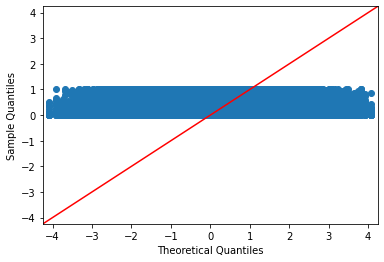

In [129]:
fig1= sm.qqplot(X_train, line='45')

In [130]:
from tensorflow.keras.layers import InputLayer
from keras.optimizers import SGD
Num_epochs=100
Batch_size=32

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], )))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
#model.add(Dense(128,activation='hard_sigmoid'))
model.add(Dense(1, activation='hard_sigmoid'))
print(model.summary())


opt= SGD(learning_rate=0.01)
opt1=keras.optimizers.Adam(learning_rate=0.0001)
loss='mean_squared_error'
loss1='binary_crossentropy'
model.compile(loss=loss, optimizer=opt1, metrics=['accuracy'])

#checkpoint: store the best model
metric = 'val_accuracy'
ckpt_model = 'wnv_weights.best.hdf5'
checkpoint = ModelCheckpoint(ckpt_model,monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list=[checkpoint]

print('Starting Training')
#train the model, store the results for plotting
history=model.fit(X_train, 
                  y_train, 
                  validation_data=(X_test, y_test), 
                  epochs=Num_epochs, 
                  batch_size=Batch_size, 
                  callbacks=callbacks_list, 
                  verbose=0)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                544       
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________
None
Starting Training

Epoch 1: val_accuracy improved from -inf to 0.80658, saving model to wnv_weights.best.hdf5

Epoch 2: val_accuracy did not improve from 0.80658

Epoch 3: val_acc

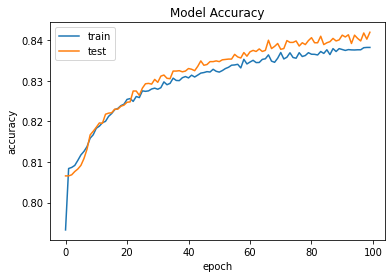

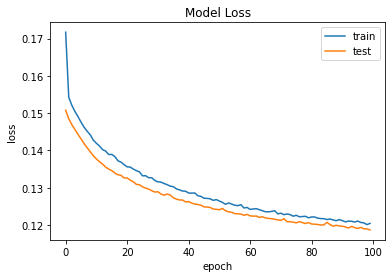

accuracy: 84.20%


In [131]:


# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


# print final accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    


350/350 [==============================] - 1s 3ms/step
[[9015   13]
 [2009  156]]


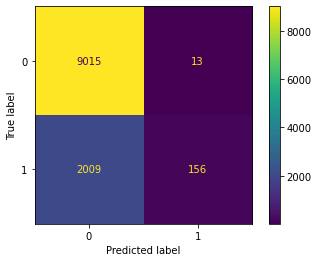

In [132]:
predictions = model.predict(X_test).astype(int)
y_pred=(predictions > 0.5)
cm= confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [133]:
from sklearn.metrics import roc_curve
y_preds=model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)


350/350 [==============================] - 1s 2ms/step


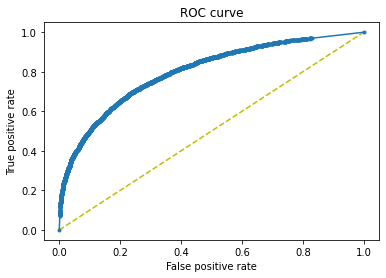

In [134]:
plt.figure(1)
plt.plot([0,1],[0,1],'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()